In [1]:
import os, sys, requests, zipfile
import geopandas as gpd
import pandas as pd
sys.path.append('..')
%load_ext autoreload

In [2]:
%autoreload 2
from onstove import OnStove, DataProcessor, RasterLayer, VectorLayer
# from onstove.raster import interpolate
import time

In [3]:
output_directory = "KEN"

In [4]:
results = OnStove.read_model(f"{output_directory}/results.pkl")

In [16]:
from copy import deepcopy
results_copy = deepcopy(results)

In [62]:
import pandas as pd
import pulp
import numpy as np

def prioritization(data, urban):

    # in the final code I want people to be able to use parameters named future_share_urban and future_share_rural and this helps us distinguish between rural and urban
    gdf = data.reset_index()
    if urban:
        mask = gdf['IsUrban'] > 20  
    else:
        mask = gdf['IsUrban'] < 20
    
    res = gdf[mask].copy() 
    results = res.set_index('index')


    # Turned everything to numpy arrays because ChatGPT said it would be faster
    populations = results['Calibrated_pop'].to_numpy()
    elec = (results['net_benefit_Electricity'] * results['Households']).fillna(0).to_numpy()
    lpg = (results['net_benefit_LPG'] * results['Households']).fillna(0).to_numpy()
    charics = (results['net_benefit_Charcoal ICS'] * results['Households']).fillna(0).to_numpy()
    total_population = populations.sum()
    n = len(results)

    # Set up the Problem
    prob = pulp.LpProblem("MaximizeNetBenefit", pulp.LpMaximize)

    # Define decision variables, using continues, because the other category is too slow. I am forcing three parameters here, but in reality we would want
    # one for each stove with future_shares > 0
    x = pulp.LpVariable.dicts("x", [(i, j) for i in range(n) for j in range(3)], lowBound=0, upBound=1, cat="Continuous")

    # Has to be made general
    matrix = np.stack([elec, lpg, charics], axis=1)

    # Same here
    prob += pulp.lpSum(matrix[i, j] * x[i, j] for i in range(n) for j in range(3)), "TotalMaxNetBenefit"

    # Constraint 1: Each row must contribute to exactly one technology
    for i in range(n):
        prob += pulp.lpSum(x[i, j] for j in range(3)) == 1, f"RowSelection_{i}"

    # Constraint 2: Maintain population proportions
    prob += pulp.lpSum(populations[i] * x[i, 0] for i in range(n)) == 0.50 * total_population, "PopulationA"
    prob += pulp.lpSum(populations[i] * x[i, 1] for i in range(n)) == 0.30 * total_population, "PopulationB"
    prob += pulp.lpSum(populations[i] * x[i, 2] for i in range(n)) == 0.20 * total_population, "PopulationC"

    # Solve using the CBC solver
    prob.solve(pulp.PULP_CBC_CMD(msg=0))

    print("Status:", pulp.LpStatus[prob.status])

    # Extract results as a NumPy array for efficiency
    selected = np.array([[x[i, j].varValue for j in range(3)] for i in range(n)])
    selected_elec, selected_lpg, selected_charics = selected[:, 0], selected[:, 1], selected[:, 2]

    return selected_elec, selected_lpg, selected_charics


In [63]:
#Creating columns
results.gdf["Electricity"] = 0.0
results.gdf["LPG"] = 0.0
results.gdf['Charcoal ICS'] = 0.0

In [65]:
selected_elec, selected_lpg, selected_charics = prioritization(results.gdf, False)

Status: Optimal


In [66]:
#Filling with rural rows
results.gdf.loc[rural, 'Electricity'] = selected_elec
results.gdf.loc[rural, 'LPG'] = selected_lpg
results.gdf.loc[rural, 'Charcoal ICS'] = selected_charics

In [68]:
selected_elec, selected_lpg, selected_charics = prioritization(results.gdf, True)

Status: Optimal


In [69]:
#Filling with urban rows
results.gdf.loc[urban, 'Electricity'] = selected_elec
results.gdf.loc[urban, 'LPG'] = selected_lpg
results.gdf.loc[urban, 'Charcoal ICS'] = selected_charics

In [70]:
def prio(row):
    priorities = []
    if row['Electricity'] > 0:
        priorities.append('Electricity')
    if row['LPG'] > 0:
        priorities.append('LPG')
    if row['Charcoal ICS'] > 0:
        priorities.append('Charcoal ICS')
    return ' and '.join(priorities)

In [71]:
results.gdf['Prioritized_hh'] = results.gdf.apply(prio, axis=1)

In [72]:
cmap = {"Biomass ICS (ND)": '#6F4070', "LPG": '#66C5CC', "Biomass": '#FFB6C1',
        "Biomass ICS (FD)": '#af04b3', "Pellets ICS (FD)": '#ef02f5',
        "Charcoal": '#364135', "Charcoal ICS": '#d4bdc5',
        "Charcoal ICS and Charcoal ICS": '#d4bdc5',
        "AND":"Purple",
        "Biogas": '#73AF48', "Biogas and Biomass ICS (ND)": "#F6029E",
        "Biogas and Biomass ICS (FD)": "#F6029E",
        "Biogas and Pellets ICS (FD)": "#F6029E",
        "Biogas and LPG": "#0F8554", "Biogas and Biomass": "#266AA6",
        "Biogas and Charcoal": "#3B05DF",
        "LPG and Charcoal ICS": "magenta",
        "Biogas and Charcoal ICS": "#3B59DF",
        "Electricity": '#CC503E', "Electricity and Biomass ICS (ND)": "#B497E7",
        "Electricity and Biomass ICS (FD)": "#B497E7",
        "Electricity and Pellets ICS (FD)": "#B497E7",
        "Electricity and LPG": "#E17C05", "Electricity and Biomass": "#FFC107",
        "Electricity and Charcoal ICS": "#660000",
        "Electricity and Biogas": "#f97b72",
        'Biogas and Biogas': "#f97b72",
        '':"Gray",
        "LPG and LPG": 'Black',
        "None": "Grey",
        "Electricity and Charcoal": "#FF0000"}


# This becomes super messy as the code is already done so you have stuff like 'Electricity and Charcoal ICS and Electricity and Charcoal ICS'
labels = {"Biogas and Electricity": "Electricity and Biogas",
          "Biogas and Bioags": "Biogas",
          "LPG and LPG":"LPG",
          "Electricity and Electricity and Charcoal ICS":'Electricity and Charcoal ICS',
          'Charcoal ICS and Electricity and Charcoal ICS':'Electricity and Charcoal ICS',
          'Electricity and Charcoal ICS and Electricity':'Electricity and Charcoal ICS',
          'Electricity and Charcoal ICS and Electricity and Charcoal ICS':'Electricity and Charcoal ICS',
          'Electricity and Charcoal ICS and Charcoal ICS':'Electricity and Charcoal ICS',
          "Charcoal ICS and Charcoal ICS":"Charcoal ICS",
          'LPG and Charcoal ICS and LPG and Charcoal ICS':"LPG and Charcoal ICS",
          'LPG and Electricity':"Electricity and LPG",
          'LPG and Electricity and LPG':"Electricity and LPG",
          'Electricity and Electricity and LPG':'Electricity and LPG',
          'LPG and Biogas': "Biogas and LPG",
          'Charcoal ICS and Biogas': "Biogas and Charcoal ICS",
          'Charcoal ICS and Electricity': "Electricity and Charcoal ICS",
          "Electricity and Electricity": "Electricity",
          'Collected Traditional Biomass': 'Biomass',
          'Collected Improved Biomass': 'Biomass ICS (ND)',
          'LPG and LPG and Charcoal ICS': "LPG and Charcoal ICS",
          'LPG and Charcoal ICS and Charcoal ICS':'LPG and Charcoal ICS',
          'LPG and Charcoal ICS and LPG': "LPG and Charcoal ICS",
          'Charcoal ICS and LPG and Charcoal ICS': "LPG and Charcoal ICS",
          'Traditional Charcoal': 'Charcoal',
          'Electricity and LPG and Electricity':'Electricity and LPG',
          'Electricity and LPG and LPG':'Electricity and LPG',
          'Electricity and LPG and Electricity and LPG':'Electricity and LPG',
          ' and ': "",
          'Biomass and Biomass':'Biomass',
          'Biomass Forced Draft': 'Biomass ICS (FD)',
          'Pellets Forced Draft': 'Pellets ICS (FD)'}

<Axes: >

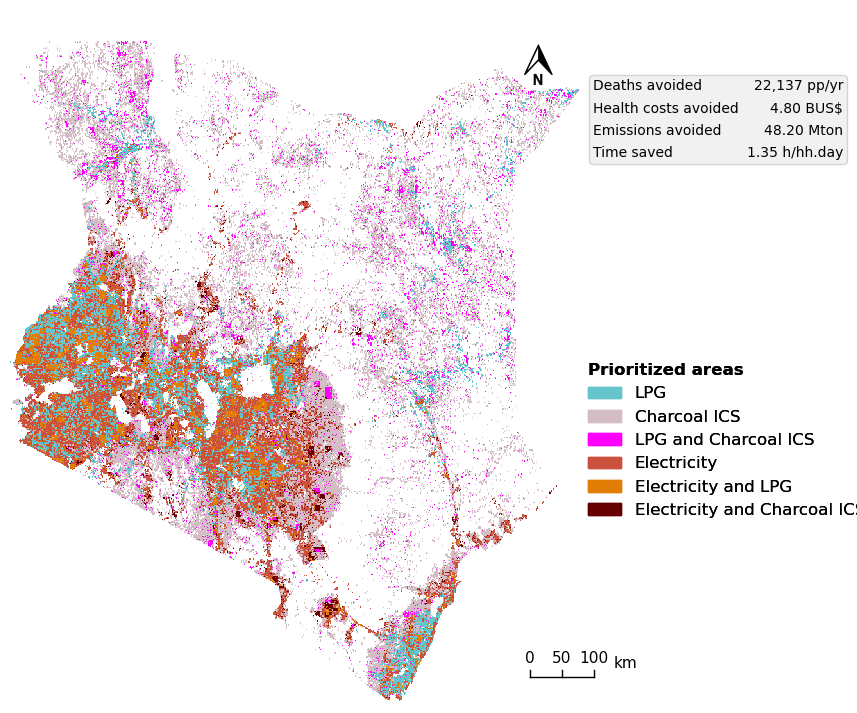

In [73]:
scale_bar_prop = dict(size=100000, style='double', textprops=dict(size=11), location=(1, 0.02),
                      linekw=dict(lw=1, color='black'), extent=0.01, loc='lower center')
north_arrow_prop = dict(size=30, location=(0.92, 0.92), linewidth=0.5)


#Stats not updated so probably wrong.
results.plot('Prioritized_hh', cmap=cmap,
                   labels=labels,
                   legend_position=(1, 0.5), 
                   figsize=(13, 9),  
                   legend_title='Prioritized areas',
                   stats=True, 
                   scale_bar=scale_bar_prop, north_arrow=north_arrow_prop, save_as='map.pdf')